## Tic-Tac-Toe Agent

#### Importing libraries

In [6]:
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [7]:
from TCGame_Env import TicTacToe

In [9]:
Q_state([1,2,3])

'1-2-3'

In [8]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [277]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] 
    return valid_Actions

In [228]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy



Lets try out different stratagies for Epsilon decay and see the curve

Better rate is such that in initial state policy should be more exploratory but in later state it starts becoming greedy

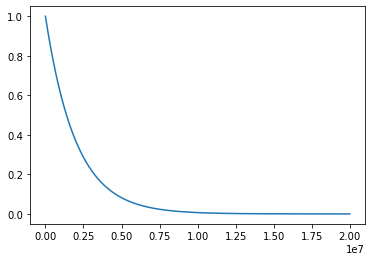

In [278]:
epsilon_values_over_time = []
for time in range(20000000):
    epsilon = np.exp(-0.0000005*time)
    epsilon_values_over_time.append(epsilon)

plt.plot(epsilon_values_over_time)
plt.show()

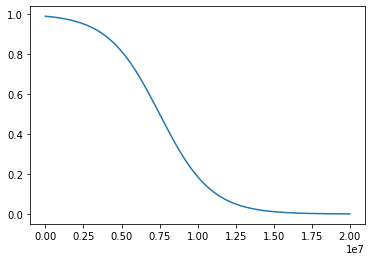

In [279]:
epsilon_values_over_time = []
for time in range(20000000):
    epsilon = - 1/ (1 + np.exp((-time+7500000)/1700000)) + 1
    epsilon_values_over_time.append(epsilon)

plt.plot(epsilon_values_over_time)
plt.show()

From above two graphs we can see, in second stratagy, in initial stage, there is more exploration happening in compare with the first graph and thus it is expected that using second logic of epsilon decay, we should be able to learn about more state-actions

We will try out both of the stratagies anyways to compare the actual result

In [231]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
# Defining epsilon-greedy policy.
def epsilon_greedy_stratagy_1(state, time):
    epsilon = np.exp(-0.0000005*time)
    #Taking random number between 0 and 1
    z = np.random.random()       
    
    if z > epsilon:
        action = max(Q_dict[Q_state(state)],key=Q_dict[Q_state(state)].get)
    else:
        action = random.sample(valid_actions(state),1)[0]   
    
    return action

In [232]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
# Defining epsilon-greedy policy.
def epsilon_greedy_stratagy_2(state, time):
    epsilon = - 1/ (1 + np.exp((-time+7500000)/1700000)) + 1
    #Taking random number between 0 and 1
    z = np.random.random()       
    
    if z > epsilon:
        action = max(Q_dict[Q_state(state)],key=Q_dict[Q_state(state)].get)
    else:
        action = random.sample(valid_actions(state),1)[0]   
    
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [233]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)

def reset_dictionaries():
    Q_dict = collections.defaultdict(dict)
    States_track =collections.defaultdict(dict)

In [234]:
reset_dictionaries()

In [235]:
# Initialise few random states to be tracked
def initialise_tracking_states():
    States_track['3-x-x-2-x-x-x-x-x'][(5,5)] = [] #More likely to occur
    States_track['4-x-x-5-x-x-x-x-x'][(8,7)] = [] #More likely to occur
    
    States_track['3-x-x-2-8-x-x-x-9'][(5,5)] = [] #Where Agent wins
    States_track['5-x-7-x-2-x-x-x-6'][(1,3)] = [] #Where Agent wins
    States_track['9-x-3-5-4-x-2-x-6'][(7,7)] = [] #Where Agent Wins (less likely to occur)

    States_track['x-x-x-x-5-x-x-8-x'][(0,1)] = [] #Where Agent or Environment can win
    
    States_track['9-x-x-3-x-4-7-8-6'][(4,5)] = [] #Where Environment can win (less likely to occur)
    States_track['3-x-4-x-2-x-8-7-5'][(3,1)] = [] #Where Environment can win (less likely to occur)
    
    States_track['x-1-7-2-6-3-8-5-4'][(0,9)] = [] #Where Tie (rarely occur)


In [236]:
#Defining a function to save the Q-dictionary as a pickle file

def save_pkl_file(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [237]:
def save_states_track():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [238]:
initialise_tracking_states()

#### Define hyperparameters 

In [239]:
EPISODES = 20000000
learning_rate = 0.10
GAMMA = 0.9
episodes_to_save = 2500
chunk_size = int(EPISODES / 100)

### Q-update loop 

In [240]:
chunk_count = 0

total_reward = 0
reward_in_chunk = 0
    
win_count = 0
loss_count = 0
tie_count = 0

for episode in range(EPISODES):
    env = TicTacToe()
    
    reward=0
    curr_state = env.state
    
    add_to_dict(curr_state)
    
    terminal = False

    
    while not(terminal):
        curr_action = epsilon_greedy_stratagy_1(curr_state, episode)
        
        next_state,reward,terminal = env.step(curr_state,curr_action) 
        
        curr_state_str = Q_state(curr_state)
        next_state_str = Q_state(next_state)
        

        if terminal:
            q_value = 0
            
            # Tracking the count of games won by agent and environment
            if reward == 10:
                win_count += 1
            elif reward == -10:
                loss_count += 1
            else:
                tie_count += 1
        else:
            add_to_dict(next_state)
            action_max_q_val = max(Q_dict[next_state_str],key=Q_dict[next_state_str].get)
            q_value = Q_dict[next_state_str][action_max_q_val]

        Q_dict[curr_state_str][curr_action] += learning_rate * ((reward + (GAMMA * (q_value))) - Q_dict[curr_state_str][curr_action]) 
        curr_state = next_state

        total_reward += reward
        reward_in_chunk += reward

    if (episode + 1) % chunk_size == 0:
        chunk_count += 1
        print("Chunk Number", chunk_count, " Win Count:", win_count, " Loss Count:", loss_count, " Tie Count:", tie_count, " Total reward in Chunk:", reward_in_chunk)
        win_count = loss_count = tie_count = reward_in_chunk =0
        

    if ((episode + 1) % episodes_to_save) == 0:   
        save_states_track()

save_pkl_file(States_track,'States_tracked_st1')   
save_pkl_file(Q_dict,'Policy_st1')

Chunk Number 1  Win Count: 50180  Loss Count: 57046  Tie Count: 92774  Total reward in Chunk: -743526
Chunk Number 2  Win Count: 51982  Loss Count: 56040  Tie Count: 91978  Total reward in Chunk: -713345
Chunk Number 3  Win Count: 55968  Loss Count: 54025  Tie Count: 90007  Total reward in Chunk: -647920
Chunk Number 4  Win Count: 64998  Loss Count: 50510  Tie Count: 84492  Total reward in Chunk: -509851
Chunk Number 5  Win Count: 74931  Loss Count: 47030  Tie Count: 78039  Total reward in Chunk: -359122
Chunk Number 6  Win Count: 85599  Loss Count: 43101  Tie Count: 71300  Total reward in Chunk: -195120
Chunk Number 7  Win Count: 96776  Loss Count: 39349  Tie Count: 63875  Total reward in Chunk: -27434
Chunk Number 8  Win Count: 106493  Loss Count: 35840  Tie Count: 57667  Total reward in Chunk: 120846
Chunk Number 9  Win Count: 115856  Loss Count: 32465  Tie Count: 51679  Total reward in Chunk: 263388
Chunk Number 10  Win Count: 125089  Loss Count: 29204  Tie Count: 45707  Total rewa

Chunk Number 82  Win Count: 197517  Loss Count: 12  Tie Count: 2471  Total reward in Chunk: 1510979
Chunk Number 83  Win Count: 197522  Loss Count: 18  Tie Count: 2460  Total reward in Chunk: 1510874
Chunk Number 84  Win Count: 197529  Loss Count: 19  Tie Count: 2452  Total reward in Chunk: 1510991
Chunk Number 85  Win Count: 197605  Loss Count: 7  Tie Count: 2388  Total reward in Chunk: 1512001
Chunk Number 86  Win Count: 197641  Loss Count: 10  Tie Count: 2349  Total reward in Chunk: 1511982
Chunk Number 87  Win Count: 197488  Loss Count: 18  Tie Count: 2494  Total reward in Chunk: 1510473
Chunk Number 88  Win Count: 197648  Loss Count: 17  Tie Count: 2335  Total reward in Chunk: 1512404
Chunk Number 89  Win Count: 197498  Loss Count: 12  Tie Count: 2490  Total reward in Chunk: 1510574
Chunk Number 90  Win Count: 197487  Loss Count: 16  Tie Count: 2497  Total reward in Chunk: 1510711
Chunk Number 91  Win Count: 197676  Loss Count: 13  Tie Count: 2311  Total reward in Chunk: 1512333
C

#### Check the Q-dictionary

In [241]:
len(Q_dict)

1728903

In [242]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
#  5 |   | 7
# -  -   -
#   | 2 | 
# -  -  -
#  |   | 6

Q_dict['5-x-7-x-2-x-x-x-6']

{(1, 1): -0.1,
 (1, 3): 0,
 (1, 9): 0,
 (3, 1): 0,
 (3, 3): 0,
 (3, 9): 0,
 (5, 1): 0,
 (5, 3): -0.1,
 (5, 9): 0,
 (6, 1): 0,
 (6, 3): -0.19,
 (6, 9): 0,
 (7, 1): 0,
 (7, 3): 0,
 (7, 9): 0}

From above Q-Table result, we can get sense that even after 20 millions episod this state '5-x-7-x-2-x-x-x-6' isn't been learnt properly

This indicates that our learning was more exploitation of already known state-actions and not enouth exploration has been done.

### Learning with stratagy 2

In [245]:
reset_dictionaries()
initialise_tracking_states()

In [246]:
chunk_count = 0

total_reward = 0
reward_in_chunk = 0
    
win_count = 0
loss_count = 0
tie_count = 0

for episode in range(EPISODES):
    env = TicTacToe()
    
    reward=0
    curr_state = env.state
    
    add_to_dict(curr_state)
    
    terminal = False

    
    while not(terminal):
        curr_action = epsilon_greedy_stratagy_2(curr_state, episode)
        
        next_state,reward,terminal = env.step(curr_state,curr_action) 
        
        curr_state_str = Q_state(curr_state)
        next_state_str = Q_state(next_state)
        
        if terminal:
            q_value = 0
            
            if reward == 10:
                win_count += 1
            elif reward == -10:
                loss_count += 1
            else:
                tie_count += 1
        else:
            add_to_dict(next_state)
            action_max_q_val = max(Q_dict[next_state_str],key=Q_dict[next_state_str].get)
            q_value = Q_dict[next_state_str][action_max_q_val]

        Q_dict[curr_state_str][curr_action] += learning_rate * ((reward + (GAMMA * (q_value))) - Q_dict[curr_state_str][curr_action]) 
        curr_state = next_state

        total_reward += reward
        reward_in_chunk += reward

    if (episode + 1) % chunk_size == 0:
        chunk_count += 1
        print("Chunk Number", chunk_count, " Win Count:", win_count, " Loss Count:", loss_count, " Tie Count:", tie_count, " Total reward in Chunk:", reward_in_chunk)
        win_count = loss_count = tie_count = reward_in_chunk =0
        

    if ((episode + 1) % episodes_to_save) == 0:   
        save_states_track()

save_pkl_file(States_track,'States_tracked_st2')   
save_pkl_file(Q_dict,'Policy_st2')

Chunk Number 1  Win Count: 50729  Loss Count: 56970  Tie Count: 92301  Total reward in Chunk: -736266
Chunk Number 2  Win Count: 50835  Loss Count: 56633  Tie Count: 92532  Total reward in Chunk: -732227
Chunk Number 3  Win Count: 51042  Loss Count: 56831  Tie Count: 92127  Total reward in Chunk: -731017
Chunk Number 4  Win Count: 51227  Loss Count: 56675  Tie Count: 92098  Total reward in Chunk: -727302
Chunk Number 5  Win Count: 51287  Loss Count: 56421  Tie Count: 92292  Total reward in Chunk: -724501
Chunk Number 6  Win Count: 51415  Loss Count: 56544  Tie Count: 92041  Total reward in Chunk: -723321
Chunk Number 7  Win Count: 51764  Loss Count: 56152  Tie Count: 92084  Total reward in Chunk: -716398
Chunk Number 8  Win Count: 52164  Loss Count: 56109  Tie Count: 91727  Total reward in Chunk: -711278
Chunk Number 9  Win Count: 53062  Loss Count: 55924  Tie Count: 91014  Total reward in Chunk: -699794
Chunk Number 10  Win Count: 53114  Loss Count: 55980  Tie Count: 90906  Total rewa

Chunk Number 81  Win Count: 198322  Loss Count: 450  Tie Count: 1228  Total reward in Chunk: 1516867
Chunk Number 82  Win Count: 198456  Loss Count: 420  Tie Count: 1124  Total reward in Chunk: 1519903
Chunk Number 83  Win Count: 198452  Loss Count: 346  Tie Count: 1202  Total reward in Chunk: 1517883
Chunk Number 84  Win Count: 198816  Loss Count: 236  Tie Count: 948  Total reward in Chunk: 1524192
Chunk Number 85  Win Count: 198657  Loss Count: 293  Tie Count: 1050  Total reward in Chunk: 1520658
Chunk Number 86  Win Count: 198800  Loss Count: 243  Tie Count: 957  Total reward in Chunk: 1523397
Chunk Number 87  Win Count: 198890  Loss Count: 204  Tie Count: 906  Total reward in Chunk: 1525292
Chunk Number 88  Win Count: 198893  Loss Count: 214  Tie Count: 893  Total reward in Chunk: 1525509
Chunk Number 89  Win Count: 198932  Loss Count: 178  Tie Count: 890  Total reward in Chunk: 1524729
Chunk Number 90  Win Count: 198921  Loss Count: 194  Tie Count: 885  Total reward in Chunk: 1524

In [247]:
len(Q_dict)

3129879

We can clearly see that using 2nd stratagy of epsilon decay, now we have learnt about almost twice states in comparision with stratagy 1.

### Check the Q-Table suggestions for the given states
Lets try for few states and see according to our Q-Table, which action should be taken

In [254]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
#  5 |   | 7
# -  -   -
#   | 2 | 
# -  -  -
#  |   | 6
max(Q_dict['5-x-7-x-2-x-x-x-6'],key=Q_dict['5-x-7-x-2-x-x-x-6'].get)

(1, 3)

In [255]:
#  3 |   | 
# -  -   -
# 2 | 8 | 
# -  -  -
#  |   | 9
max(Q_dict['3-x-x-2-8-x-x-x-9'],key=Q_dict['3-x-x-2-8-x-x-x-9'].get)

(5, 5)

As we can see, this Q-table is giving us perfect suggestion for next action based on the given state

### Check the states tracked for Q-values convergence

Lets check couple state actions from state tracking table and see how well the q-value for those state action has converged

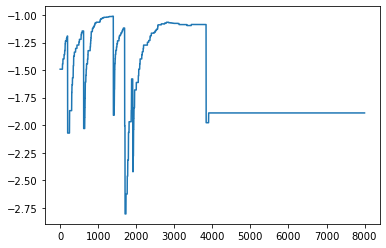

In [260]:
q_val = States_track['3-x-x-2-x-x-x-x-x'][(5, 5)] #this state action is more likely to occur
plt.plot(q_val)
plt.show()

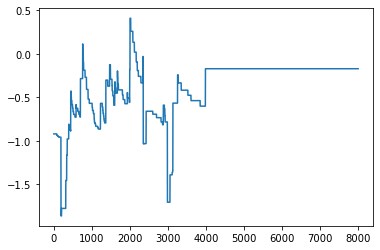

In [262]:
q_val = States_track['4-x-x-5-x-x-x-x-x'][(8, 7)] #this state action is more likely to occur
plt.plot(q_val)
plt.show()

The above two states - as they have almost all the values as NA, the probability of those state occuring is more

And thus we can see more movement (learning) of Q-value in those state-action

However, as we can see, after initial movements, the Q-value for these state-action has converged well

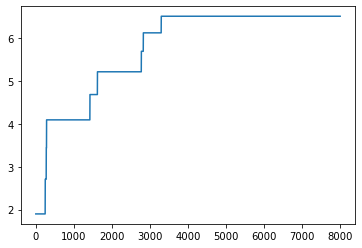

In [264]:
q_val = States_track['3-x-x-2-8-x-x-x-9'][(5,5)] #state-action where agent wins
plt.plot(q_val)
plt.show()

This state-action is such where agent wins so Q-value for this state action should be positive which we can see

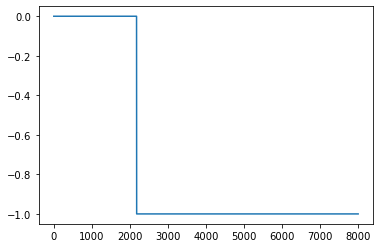

In [269]:
q_val = States_track['9-x-x-3-x-4-7-8-6'][(4,5)] #State-action where it is more likely that environment will win
plt.plot(q_val)
plt.show()


This state-action is such where it is more likely that environment will win so Q-value for this state action should be negative which we can see

However, as we can see there are many slots are filled in the board, this state is less likely to occur so we can expect less movement (and that can also be taken as slow in actual convergence)

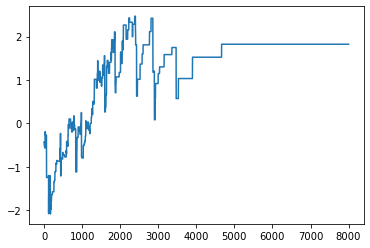

In [274]:
q_val = States_track['x-x-x-x-5-x-x-8-x'][(0,1)] #State-Action where agent or environment any of them can win
plt.plot(q_val)
plt.show()


This is the state where environment or agent any of these two can win (by taking right action)

We can see, in initial stage the q-value of this state-action was negative, but once agent has learnt enough and have started taking greedy decision based on Q-Table exploitation, Q-value of this state-action has increased and later convegred

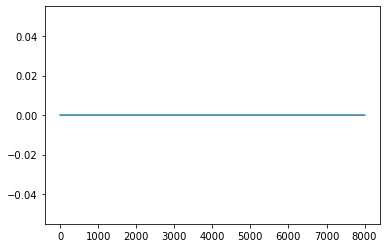

In [281]:
q_val = States_track['x-1-7-2-6-3-8-5-4'][(0,9)] #Extremly rare occuring state action
plt.plot(q_val)
plt.show()
